In [36]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence

from PIL import Image

In [37]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

print(f"Using {device}")

Using cuda


In [38]:
from ultralytics import YOLO
yolo_model = YOLO("yolov8n.pt")
yolo_model = yolo_model.model.model[:10]
yolo_model = yolo_model.to(device)
yolo_model.eval()
print(yolo_model)

Sequential(
  (0): Conv(
    (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
    (act): SiLU(inplace=True)
  )
  (1): Conv(
    (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
    (act): SiLU(inplace=True)
  )
  (2): C2f(
    (cv1): Conv(
      (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
      (act): SiLU(inplace=True)
    )
    (cv2): Conv(
      (conv): Conv2d(48, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
      (act): SiLU(inplace=True)
    )
    (m): ModuleList(
      (0): Bottleneck(
        (cv1): Conv(
        

In [39]:
# Extract features from images
features = {}
directory = 'Images'

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

for img_name in tqdm(os.listdir(directory)):
    img_path = os.path.join(directory, img_name)
    image = Image.open(img_path).convert('RGB')
    image = transform(image).unsqueeze(0).to(device)
    feature = yolo_model(image)
    feature = feature.view(feature.size(0), -1).detach().cpu().numpy()[0]
    image_id = img_name.split('.')[0]
    features[image_id] = feature

  0%|          | 0/8091 [00:00<?, ?it/s]

In [40]:
# Store features in pickle
with open(os.path.join('./', 'features.pkl'), 'wb') as f:
    pickle.dump(features, f)

In [41]:
# Load features from pickle
with open(os.path.join('./', 'features.pkl'), 'rb') as f:
    features = pickle.load(f)

In [42]:
print(features['3250076419_eb3de15063'])
print(features['3747543364_bf5b548527'])

print(features['3250076419_eb3de15063'].shape)
print(len(features))
feature_size = features['3250076419_eb3de15063'].shape[0]

[    0.27217      0.1477     0.19528 ...    -0.27595    -0.26205    -0.26939]
[    0.45006     0.44025     0.38045 ...    -0.15023    -0.10277   -0.084997]
(12544,)
8091


In [43]:
# Load captions from the text file
with open(os.path.join('./', 'captions.txt'), 'r') as f:
    next(f)
    captions_doc = f.read()

In [44]:
# Create mapping of image to captions
mapping = {}
for line in tqdm(captions_doc.split('\n')):
    tokens = line.split(',')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    image_id = image_id.split('.')[0]
    caption = " ".join(caption)
    if image_id not in mapping:
        mapping[image_id] = []
    mapping[image_id].append(caption)

  0%|          | 0/40456 [00:00<?, ?it/s]

In [45]:
# Clean the captions
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            caption = captions[i]
            caption = caption.lower()
            caption = caption.replace('[^A-Za-z]', '')
            caption = caption.replace('\s+', ' ')
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
            captions[i] = caption

In [46]:
# Before preprocess of text
print(mapping['1000268201_693b08cb0e'])

['A child in a pink dress is climbing up a set of stairs in an entry way .', 'A girl going into a wooden building .', 'A little girl climbing into a wooden playhouse .', 'A little girl climbing the stairs to her playhouse .', 'A little girl in a pink dress going into a wooden cabin .']


In [47]:
# Preprocess the text
clean(mapping)

# After preprocess of text
print(mapping['1000268201_693b08cb0e'])

['startseq child in pink dress is climbing up set of stairs in an entry way endseq', 'startseq girl going into wooden building endseq', 'startseq little girl climbing into wooden playhouse endseq', 'startseq little girl climbing the stairs to her playhouse endseq', 'startseq little girl in pink dress going into wooden cabin endseq']


In [48]:
all_captions = [caption for captions in mapping.values() for caption in captions]
len(all_captions)

40455

In [49]:
all_captions[:10]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri-colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

In [50]:
import torchtext
from torchtext.data import get_tokenizer

tokenizer = get_tokenizer("basic_english")

# Tokenize the text
tokenized_text = [tokenizer(caption) for caption in all_captions]

vocab = torchtext.vocab.build_vocab_from_iterator(tokenized_text)
vocab_size = len(vocab)
print(vocab_size)

8896


In [51]:
print(vocab['you'])

1377


In [52]:
max_length = max(len(caption.split()) for caption in all_captions)
print(max_length)

35


In [53]:
image_ids = list(mapping.keys())
split = int(len(image_ids)*0.75)
train = image_ids[:split]
test = image_ids[split:]

In [54]:
def one_hot(a, num_classes):
    out = np.zeros(num_classes)
    out[a] = 1
    return out
    

In [55]:
class CaptionDataset(Dataset):
    def __init__(self, data_keys, mapping, features, tokenizer, max_length):
        self.data_keys = data_keys
        self.mapping = mapping
        self.features = features
        self.tokenizer = tokenizer
        self.max_length = max_length
        

    def __len__(self):
        return len(self.data_keys)

    def __getitem__(self, idx):
        key = self.data_keys[idx]
        captions = self.mapping[key]

        # caption = captions[np.random.choice(len(captions))]
        caption = captions[0]
        input1, input2, y = torch.zeros((1, feature_size)), torch.zeros(max_length).int(), torch.zeros((max_length, vocab_size))
        input1[0] = torch.as_tensor(features[key])
        tokens = self.tokenizer(caption)
        caption_indices = [vocab[token] for token in tokens]

        for i in range(1, len(caption_indices)):
            in_seq, out_seq = caption_indices[i-1], caption_indices[i]

            out_seq = int(out_seq)
            out_seq = one_hot(out_seq, num_classes=vocab_size)
         
            input2[i-1] = int(in_seq)

            y[i-1] = torch.as_tensor(out_seq)

        return input1, input2, y, idx


In [94]:
batch_size = 4
train_dataset = CaptionDataset(train, mapping, features, tokenizer, max_length)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)

In [95]:
print(train_dataset.__getitem__(0)[0].size())
print(train_dataset.__getitem__(0)[1].size())
print(train_dataset.__getitem__(0)[2].size())

torch.Size([1, 12544])
torch.Size([35])
torch.Size([35, 8896])


In [96]:
class Encoder(nn.Module) :
    def __init__(self, feature_size, hidden_size) :
        super(Encoder, self).__init__()
        self.image_feature_layer = nn.Sequential(
            # nn.Dropout(0.4),
            nn.Linear(feature_size, 4096),
            nn.ReLU(),
            nn.Linear(4096, hidden_size),   
            nn.ReLU()
        )

    def forward(self, image_input) :
        return self.image_feature_layer(image_input) 


class Decoder(nn.Module):
    def __init__(self, vocab_size, embedding_size, hidden_size):
        super(Decoder, self).__init__()
        
        self.emb = nn.Embedding(vocab_size, embedding_size, padding_idx=0)
        self.lstm = nn.LSTM(embedding_size, hidden_size, batch_first=True)
        
        self.decoder = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, vocab_size),
            # nn.ReLU()
        )

    def forward(self, sequence_input, h, c):
        se = self.emb(sequence_input)
        
        output, (h, c) = self.lstm(se, (h, c))

        output = self.decoder(output)

        return output, h, c
    

class ImageCaptioningModel(nn.Module) :
    def __init__(self, feature_size, vocab_size, embedding_size, hidden_size):
        super(ImageCaptioningModel, self).__init__()
        self.encoder = Encoder(feature_size, hidden_size)
        self.decoder = Decoder(vocab_size, embedding_size, hidden_size)

    def forward(self, image_input, sequence_input, h=None, c=None) :
        fe = self.encoder(image_input)
        c = None
        if h is None :
            if len(fe.size()) == 3 :
                fe = fe.permute(1, 0, 2)
                c = torch.randn(1, fe.shape[1], 256).to(device)
            else : 
                c = torch.randn(1, 256).to(device) 
            return self.decoder(sequence_input, fe, c)
        
        c = torch.randn(1, 256).to(device) 
        return self.decoder(sequence_input, h, c)

In [97]:
# Instantiate the model
embedding_size = 256
hidden_size = 256

model = ImageCaptioningModel(feature_size, vocab_size, embedding_size, hidden_size)
model = model.to(device)

In [98]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [99]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=10, factor=0.1, verbose=True)

In [100]:
data_iter = iter(train_loader)
single_batch = next(data_iter)

In [101]:
num_epochs = 500
for epoch in range(num_epochs) :
    total_loss = 0
    model.train()
    inputs1, inputs2, targets, _ = single_batch

    inputs1, inputs2, targets = inputs1.to(device), inputs2.to(device), targets.to(device)
    hidden, c = None, None
    output, hidden, c = model(inputs1, inputs2, hidden, c)

    mask = torch.sum(targets, dim=-1) != 0
    output_flat = output.view(-1, vocab_size)
    targets_flat = targets.view(-1, vocab_size)

    output_masked = output_flat[mask.view(-1)]
    targets_masked = targets_flat[mask.view(-1)]
    loss = criterion(output_masked, targets_masked)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    total_loss += loss.item()
    scheduler.step(total_loss)
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {total_loss:.4f}')

Epoch [1/500], Loss: 9.0877
Epoch [2/500], Loss: 9.0063
Epoch [3/500], Loss: 8.9238
Epoch [4/500], Loss: 8.8347
Epoch [5/500], Loss: 8.7356
Epoch [6/500], Loss: 8.6055
Epoch [7/500], Loss: 8.4471
Epoch [8/500], Loss: 8.2651
Epoch [9/500], Loss: 8.0181
Epoch [10/500], Loss: 7.7051
Epoch [11/500], Loss: 7.2733
Epoch [12/500], Loss: 6.7363
Epoch [13/500], Loss: 5.9171
Epoch [14/500], Loss: 5.0092
Epoch [15/500], Loss: 4.0628
Epoch [16/500], Loss: 3.6041
Epoch [17/500], Loss: 3.4091
Epoch [18/500], Loss: 3.1458
Epoch [19/500], Loss: 2.8706
Epoch [20/500], Loss: 2.6462
Epoch [21/500], Loss: 2.4861
Epoch [22/500], Loss: 2.3345
Epoch [23/500], Loss: 2.2141
Epoch [24/500], Loss: 2.0884
Epoch [25/500], Loss: 1.9493
Epoch [26/500], Loss: 1.8166
Epoch [27/500], Loss: 1.6602
Epoch [28/500], Loss: 1.5103
Epoch [29/500], Loss: 1.3785
Epoch [30/500], Loss: 1.2738
Epoch [31/500], Loss: 1.1669
Epoch [32/500], Loss: 1.0674
Epoch [33/500], Loss: 0.9769
Epoch [34/500], Loss: 0.8865
Epoch [35/500], Loss: 0

In [423]:
# # Train the model
# num_epochs = 50
                                                               
# for epoch in range(num_epochs):
#     total_loss = 0
#     model.train()

#     for batch in train_loader:
#         inputs1, inputs2, targets = batch

#         inputs1, inputs2, targets = inputs1.to(device), inputs2.to(device), targets.to(device)
#         hidden, c = None, None
#         output, hidden, c = model(inputs1, inputs2, hidden, c)

#         # Calculate the loss
#         loss = criterion(output, targets)

#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

#         total_loss += loss.item()
#     # break
#     average_loss = total_loss / len(train_loader)
#     print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {average_loss:.4f}')

In [424]:
# # Save the model
# torch.save(model.state_dict(), os.path.join('./', 'best_model.pth'))

In [102]:
# Evaluation
def idx_to_word(index):
    try:
        return vocab.get_itos()[index]
    except:
        return None

def predict_caption(model, feature, max_length):
    model.eval()
    input1 = torch.zeros((1, feature_size)).to(device)
    input1[0] = torch.as_tensor(feature)
    hidden = None
    c = None 
    input2 = torch.zeros(1).int()
    in_text = 'startseq'
    for _ in range(max_length):
        input2[0] = torch.as_tensor(vocab[in_text.split(' ')[-1]], dtype=torch.int64)
        input2 = input2.to(device)

        outputs, hidden, c = model(input1, input2, hidden, c)

        outputs = F.softmax(outputs, dim=1)

        # y_pred = torch.argmax(outputs, dim=1).squeeze(0).item()
        y_pred = torch.multinomial(outputs, 1).squeeze(0).item()
        
        word = idx_to_word(y_pred)
        in_text += ' ' + word
        
        if word is None or word == 'endseq' :
            break

    return in_text



In [426]:
# BLEU Score Calculation
from nltk.translate.bleu_score import corpus_bleu

actual, predicted = [], []

for key in tqdm(test):
    captions = mapping[key]
    y_pred = predict_caption(model, features[key], max_length)
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    actual.append(actual_captions)
    predicted.append(y_pred)

# Calculate BLEU score
bleu1 = corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0))
bleu2 = corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0))

print(f"BLEU-1: {bleu1}")
print(f"BLEU-2: {bleu2}")


  0%|          | 0/2023 [00:00<?, ?it/s]

BLEU-1: 0.0450963585589073
BLEU-2: 0.01342493711387129


In [103]:
_, _, _, ids = single_batch
print(ids)

tensor([1791, 5838, 1016, 1357])


In [80]:
# Generate caption for an image
def generate_caption(image_name) :
    image_id = image_name.split('.')[0]
    img_path = os.path.join('./', "Images", image_name)
    image = Image.open(img_path)

    captions = mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)

    y_pred = predict_caption(model, features[image_id], max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)

    plt.imshow(image)

---------------------Actual---------------------
startseq football player in purple uniform holds the ball while player in red tries to tackle him endseq
startseq football player in white is being tackled by oklahoma university player endseq
startseq "an american footballer in red outfit is attacking the player in white who is running with the ball whilst other players are nearby ." endseq
startseq sooners football player is tackling an opposing player endseq
startseq the receiver is tackled after making the catch endseq
--------------------Predicted--------------------
startseq football player in green and pink outfit attempts to made red cowboy hat is while mountainside fastest racing rolled escalators observed referring easels italy ended approaches invention busters helment wodden impersonators husky-like popped group of
None


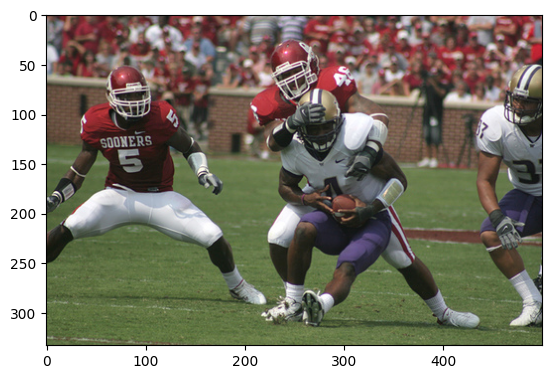

In [104]:
print(generate_caption(f'{train[1791]}.jpg'))

---------------------Actual---------------------
startseq girl in green and pink outfit attempts to climb wall made for kids endseq
startseq girl with pink hat is climbing playground wall endseq
startseq little girl climbing rock wall endseq
startseq little girl in hat climbing kiddie wall endseq
startseq young girl wearing pink hat climbs on the playground equipment endseq
--------------------Predicted--------------------
startseq girl in green pink sit pocket chair overpass partition corral pitbulls mid-swing suggestive standard cavorting shite cotton looking causing employees monitoring snowpile harmonica tented bow-like mast candle chairs puppy participant hug tank jesus made anciet
None


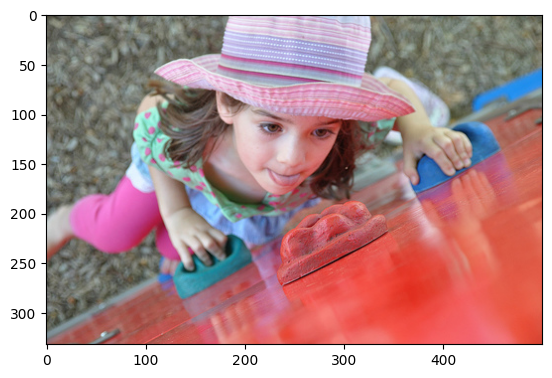

In [105]:
print(generate_caption(f'{train[5838]}.jpg'))

---------------------Actual---------------------
startseq group of children sit on bench outside and smile happily endseq
startseq five children laugh and smile on bench endseq
startseq five giggling children sit on green bench in park endseq
startseq the children enjoy something funny as they prepare to have their photo taken endseq
startseq two girls and three boys are sitting on bench laughing endseq
--------------------Predicted--------------------
startseq group of children ball while player in green and pink outfit attempts to wall raked array puffy face-down whist different-colored 84 diego goods conoes punch pro married passage church towarn competing wrist tour bedroll trooper
None


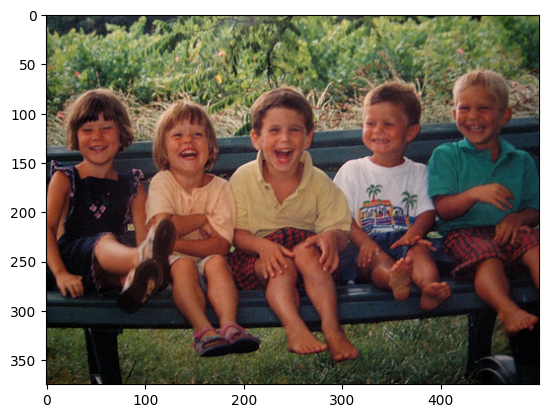

In [106]:
print(generate_caption(f'{train[1016]}.jpg'))

---------------------Actual---------------------
startseq man in cowboy hat is walking through market and reaching into his pocket endseq
startseq man in cowboy hat walks in department store endseq
startseq man in hat is making his way through store endseq
startseq man in leather jacket and cowboy hat walks through mall endseq
startseq six people inside store endseq
--------------------Predicted--------------------
startseq man in red tries to tackle children to attempts to gardening batting felled completely rope-swinging crevasse set strainer eat olympic spotted rested bodyless interacts profile logo party red footbride silhouetted frisbree favorite glares pouch i-beam
None


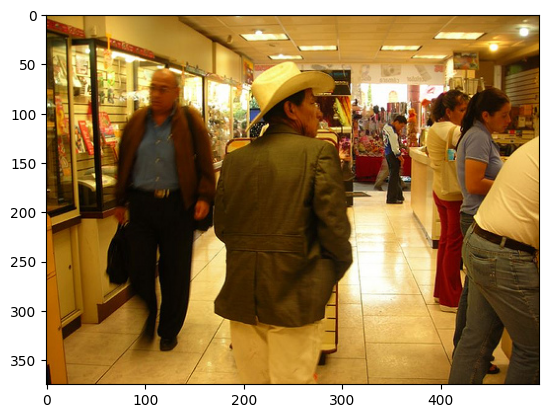

In [107]:
print(generate_caption(f'{train[1357]}.jpg'))